# **Предскзание сложности английских фильмов на основе Субтитров**

Проект:

Запрос сформирован тем, что просмотр фильмов на оригинальном языке- это популярный и действенный метод упражнений по изучению иностранных языков. Важно выбрать фильм, который подходит студенту по уровню сложности, т.е. студент понимал 50-70 % диалогов. Чтобы выполнить это условие, преподаватель должен посмотреть фильм и решить, какому уровню он соответствует. Однако это требует больших временных затрат.

Заказчику необходимо:

Разработать ML решение для автоматического определения уровня сложности англоязычных фильмов;

Имеющиеся данные:
- размеченный датасет с названиями фильмов в формате excel, субтитрами и меткой уровня сложности языка (A1/A2/B1/B2/C1/C2)
- файлы субтитров в формате .srt, отсортированные по каталогам в соответствии с уровнем сложности
- словари Oxford (на 3000 и 5000 тыс.слов), в которых слова на английском сгруппированы по уровню сложности

Какие изменения я вносил в имеющиеся данные?
- Собрал все субтитры фильмов и сериалов в единную папку- https://drive.google.com/drive/folders/13qVCq8yv25Pmc0Kll1XXhPHqPd1Nx7Vv?usp=sharing
- ('/content/drive/MyDrive/Сабы')
- Залил на гугл диск список фильмов с указанным уровнем языка- https://docs.google.com/spreadsheets/d/1RjKxOLoLakS3nIED1wUXNExDjR51s2Om/edit?usp=sharing&ouid=101205604110403851950&rtpof=true&sd=true
- ('/content/drive/MyDrive/DS/movies_labels.xlsx')
- Собрал дополненный датасет с новыми и старыми субтитрами, в котором постарался устранить дисбаланс, путем добавления новых фильмов, уровни которых были размечены через открыте источники- https://drive.google.com/drive/folders/18f0UIXSY3S8AyOFZmmMTYOaoh85Sfd0H?usp=sharing
- ('/content/drive/MyDrive/DS/Updated subs'  )
- Создал дополненный список, в котором помимо уже имеющихся данных с разметкой указал и новые фильмы и уровень их сложности- https://docs.google.com/spreadsheets/d/11PKlZEzzBNArKmdgdE5TOArWFLASmwnt/edit?usp=sharing&ouid=101205604110403851950&rtpof=true&sd=true
- ('/content/drive/MyDrive/DS/updated_movies_labels.xlsx')

In [1]:
!pip install pysrt

import pandas as pd
import os
import pysrt
import glob
import re

import seaborn as sns

!pip install pattern
import pattern
from pattern.en import lemma, lexeme

# импортируем библиотеку nltk
import nltk
# Импортируем метод word_tokenize из библиотеки nltk
from nltk.tokenize import word_tokenize

# Импортируем метод stopwords из библиотеки nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorize

from gensim.models import Word2Vec
import numpy as np

import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split

from sklearn.metrics import f1_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pysrt: filename=pysrt-1.1.2-py3-none-any.whl size=13443 sha256=cf3417a9af3c1c742fb8dd7a416037750fd896be5b5ee1efe2233ccf57dafe45
  Stored in directory: /root/.cache/pip/wheels/30/7f/e8/55de9a9b07302d9e7fe47c27910e3bea0c48536153e74bd7e6
Successfully built pysrt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.5/89.5 kB 8.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 49.

ImportError: ignored

In [ ]:
# folder path
dir_path = r'/content/drive/MyDrive/Сабы'

# list to store files
res = []

# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
      res.append(path.rpartition('.')[0])

print(res)

In [ ]:
dir_path = r'/content/drive/MyDrive/Сабы'

# list to store files
txts = []

for file in os.listdir(dir_path):
  fil = pysrt.open(os.path.join(dir_path, file), encoding='iso-8859-1')
  txt = fil.text
  txts.append(txt)

In [ ]:
сolumns = {'Titles':res, 'Texts':txts}
df1 = pd.DataFrame(сolumns)
df1


,Titles,Texts
0,"Crown, The S01E03 - Windsor.en",<i> Gina! Gina! Ella!</i>\n-Gina! Carina! Ella...
1,Suits.Episode 4- No Puedo Hacerlo,You took this case\nwithout running it by me.\...
2,"Crown, The S01E07 - Scientia Potentia Est.en","Your Majesty.\nSo, it is\nalways the Sovereign..."
3,Crazy4TV.com - Suits.S06E06.720p.BluRay.x265.H...,(HARVEY READING)\nI've been after Sutter\nfor ...
4,Suits.S01E05.1080p.BluRay.AAC5.1.x265-DTG.02.EN,Ross. Triple double. Courtesy\nof America's fa...
...,...,...
273,Mona_Lisa_Smile(2003),All her life she had wanted\nto teach at Welle...
274,The_greatest_showman(2017),âª Whoa âª\nâª Whoa âª\nâª Whoa âª\nâª ...
275,Inside_out(2015),Advertise your product or brand here<br/>conta...
276,Cinderella(1950),Cinderella\nYou're as lovely as your name\nCin...


In [ ]:
df2= pd.read_excel('/content/drive/MyDrive/DS/movies_labels.xlsx')
df2


,id,Movie,Level
0,0,10_Cloverfield_lane(2016),B1
1,1,10_things_I_hate_about_you(1999),B1
2,2,A_knights_tale(2001),B2
3,3,A_star_is_born(2018),B2
4,4,Aladdin(1992),A2/A2+
...,...,...,...
236,236,Matilda(2022),C1
237,237,Bullet train,B1
238,238,Thor: love and thunder,B2
239,239,Lightyear,B2


In [ ]:
df = df2.merge(df1, left_on = 'Movie', right_on = 'Titles', how = 'inner')
df = df.drop(['Titles', 'id'], axis= 1)

In [ ]:
df

,Movie,Level,Texts
0,10_Cloverfield_lane(2016),B1,"<font color=""#ffff80""><b>Fixed & Synced by boz..."
1,10_things_I_hate_about_you(1999),B1,"Hey!\nI'll be right with you.\nSo, Cameron. He..."
2,A_knights_tale(2001),B2,Resync: Xenzai[NEF]\nRETAIL\nShould we help hi...
3,A_star_is_born(2018),B2,"- <i><font color=""#ffffff""> Synced and correct..."
4,Aladdin(1992),A2/A2+,"<i>Oh, I come from a land\nFrom a faraway plac..."
...,...,...,...
228,Suits.S03E06.720p.HDTV.x264-mSD,C1,I lost Ava her company.\nI assume my deal\nwit...
229,Suits.S03E07.HDTV.x264-mSD,C1,Previously on\n<i>Suits...</i>\nIt's going up\...
230,Suits.S03E08.480p.HDTV.x264-mSD,C1,"I get Ava Hessington acquitted,\nDarby backs m..."
231,Suits.S03E09.480p.HDTV.x264-mSD,C1,Previously on\n<i>Suits...</i>\nI'm bonding\nw...


<Axes: xlabel='Level', ylabel='count'>

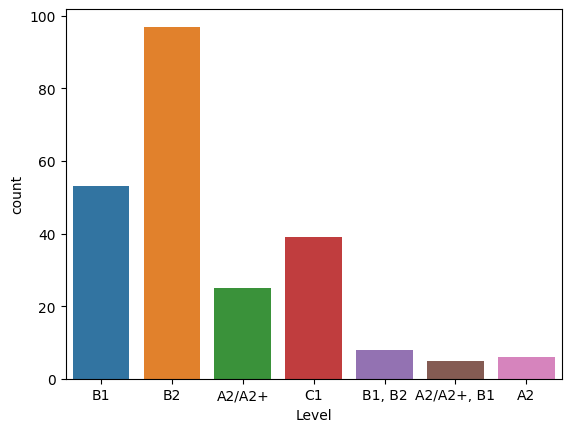

In [ ]:
#Изучим текущее распределение данных
sns.countplot(data=df, x="Level")

In [ ]:
df['Level'].unique()

array(['B1', 'B2', 'A2/A2+', 'C1', 'B1, B2', 'A2/A2+, B1', 'A2'],
      dtype=object)

Поскольку мы видим, что Группы А2/А2+ , В1,B2, А2/А2+,B1 и А2 являются довольно малочисленными, объденим их значения с А2 и B1 соответственно для сохранения некоторого баланса


In [ ]:
for i in range(len(df['Level'])):
  if df.loc[i, 'Level'] == 'A2/A2+':
    df.loc[i, 'Level'] = 'A2'
  elif df.loc[i, 'Level'] == 'B1, B2':
    df.loc[i, 'Level'] = 'B1'
  elif df.loc[i, 'Level'] == 'А2':
    df.loc[i, 'Level'] = 'A2'
  elif df.loc[i, 'Level'] == 'A2/A2+, B1':
     df.loc[i, 'Level'] = 'A2'


B2    97
B1    61
C1    39
A2    36
Name: Level, dtype: int64

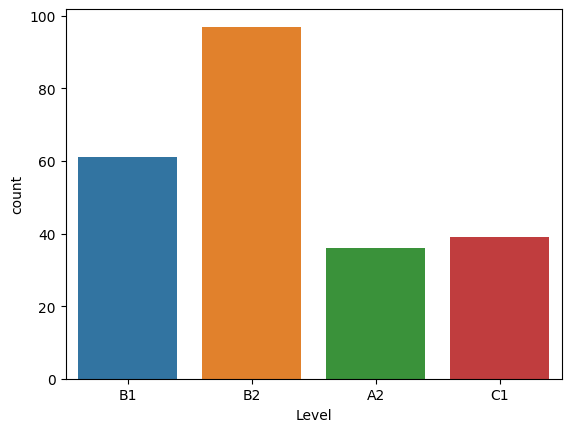

In [ ]:
sns.countplot(data=df, x="Level")
df['Level'].value_counts()
#Не идеально, но уже значительно лучше

In [ ]:
#Загружаем необходимые библиотеки для предобработки данных в датасете

nltk.download("stopwords") # поддерживает удаление стоп-слов
nltk.download('punkt') # делит текст на список предложений
nltk.download('wordnet') # проводит лемматизацию
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Проведем первичную предобработку, токенизацию и лемматизацию текста

На основе сравнительного анализа из статьи- https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/ было решено использовать лематизатор- Pattern, так как результат его работы, на выборке, указанной в задании показал, наилучший результат после StanfordNLP, в идеале было бы конечно хорошо использовать лематизатор- StanfordNLP, но мне так и не удалось запустить его из-за каких-то проблем при скачивании необходимого пакета, потениально его можно скачать на прямую, по иснутркции из https://stackoverflow.com/questions/59115414/when-i-try-to-download-stanfordnlp-en-model-it-gives-an-error, но этого не удалось сделать так как есть проблемы с серверами, согласно инфомрации на сайте

In [ ]:
#Импортируем необходимый лематайзер
!pip install pattern
import pattern
from pattern.en import lemma, lexeme

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 62.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.5/89.5 kB 10.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 92.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.4/348.4 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 64.0 MB/s eta 0:00:00
  Created wheel for pattern: filename=Pattern-3.6-py3-non

In [ ]:
# импортируем библиотеку nltk
import nltk
# Импортируем метод word_tokenize из библиотеки nltk
from nltk.tokenize import word_tokenize

# Импортируем метод stopwords из библиотеки nltk
from nltk.corpus import stopwords

# загружаем список с английскими стоп-словами в переменную stop-words
stop_words = stopwords.words('english')
# далее мы можем добавить в список стоп слов новые слова,
#как например font в примере ниже, поиграемся с этим потом через анализ частотности слов в датасете
stop_words.append('font')

# создаем список для хранения очищенных данных
cleaned_text = []

for text in df['Texts']:
    # очищаем данные
    text = re.sub("[^a-zA-Z]"," ",text)
    # приводим текст к нижнему регистру
    text = text.lower()
    # удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text)
    # Производим токенизацию
    text = word_tokenize(text)
    # с помощью цикла for поочередно проверяем каждое слово(токен) текущего сообщения
    # на вхождение в список стоп-слов. Если токен не является стоп-словом, то добавляем его в список
    text = [word for word in text if word not in stop_words]
    # для каждого слова из текущего сообщения вызываем функцию лемматизации
    text = [lemma(wd) for wd in text]
    # И приводим датасет в итоговому виду
    text = " ".join(text)
    # добавляем очищенные данные в список cleaned_text
    cleaned_text.append(text)
# записываем очищенные данные в новую колонку 'Cleaned_txt'
df['Cleaned_txt'] = cleaned_text
# и изучаем результат
df

,Movie,Level,Texts,Cleaned_txt
0,10_Cloverfield_lane(2016),B1,"<font color=""#ffff80""><b>Fixed & Synced by boz...",color ffff b fix sync bozxphd enjoy flick b cl...
1,10_things_I_hate_about_you(1999),B1,"Hey!\nI'll be right with you.\nSo, Cameron. He...",hey right cameron go nine school year army bra...
2,A_knights_tale(2001),B2,Resync: Xenzai[NEF]\nRETAIL\nShould we help hi...,resync xenzai nef retail help due list two min...
3,A_star_is_born(2018),B2,"- <i><font color=""#ffffff""> Synced and correct...",color ffffff sync correct b color ffd mrcjnthn...
4,Aladdin(1992),A2,"<i>Oh, I come from a land\nFrom a faraway plac...",oh come land faraway place caravan camel roam ...
...,...,...,...,...
228,Suits.S03E06.720p.HDTV.x264-mSD,C1,I lost Ava her company.\nI assume my deal\nwit...,lose ava company assume deal edward dead long ...
229,Suits.S03E07.HDTV.x264-mSD,C1,Previously on\n<i>Suits...</i>\nIt's going up\...,previously suit go wall tomorrow way get side ...
230,Suits.S03E08.480p.HDTV.x264-mSD,C1,"I get Ava Hessington acquitted,\nDarby backs m...",get ava hessington acquit darby back manage pa...
231,Suits.S03E09.480p.HDTV.x264-mSD,C1,Previously on\n<i>Suits...</i>\nI'm bonding\nw...,previously suit bond father speak take easy li...


In [ ]:
X = cleaned_text
y = df["Level"].values
#Далее разделим выборку на тестовую и обучающую

x_train, y_train, x_valid, y_valid = train_test_split(X, y, test_size = 0.33, random_state = 42)
len(y_valid)

77

In [ ]:
# Одним из прорабатываемых вариантов, также было кодирование целевых признаков с помощью Ordinal Encoder, для того чтобы предсказания можно было выполнять в том числе и с помощью моделей ргерессии, но от этого варианта было решено отказаться
#ce_ord = ce.OrdinalEncoder()
#y = ce_ord.fit_transform(df["Level"].values)
#ce_ord.get_params([y])

{'cols': [0],
 'drop_invariant': False,
 'handle_missing': 'value',
 'handle_unknown': 'value',
 'mapping': [{'col': 0,
   'mapping': B1     1
   B2     2
   A2     3
   C1     4
   NaN   -2
   dtype: int64,
   'data_type': dtype('O')}],
 'return_df': True,
 'verbose': 0}

Для дальнейшей векторизации текста, было решено использовать 3 различных модели, чтобы посмотреть какая из них даст наибольший результат и использовать ее в итоговой модели. Изучаемые модели: CountVectorizer, Tfidfvectorizer и Word2Vec. Метрикой, была выбрана f1_macro, так как нам одинакова важна успешность предсказания каждого из признаков.

In [ ]:
# импортируем модуль CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer()
# проводим преобразование текста c помощью CountVectorizer
CV_train = count.fit_transform(x_train).toarray()
CV_test = count.transform(y_train).toarray()

In [ ]:
# импортируем модуль TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
#преобразуем текст
TFV_train = tfidf_vectorizer.fit_transform(x_train).toarray()
TFV_test = tfidf_vectorizer.transform(y_train).toarray()

In [ ]:
# Импортируем и обрабатываем тренировочный датасет с помощью Word2Vec
from gensim.models import Word2Vec
import numpy as np

sentences = [sentence.split() for sentence in x_train]
w2v_model = Word2Vec(sentences, window=5, min_count=5, workers=4)

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

W2V_train = np.array([vectorize(sentence) for sentence in x_train])
W2V_test = np.array([vectorize(sentence) for sentence in y_train])

Изучим результаты предсказания на данных, предобработанных с помощью- CountVectorizer



In [ ]:
x_train = CV_train
y_train = CV_test

In [ ]:
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(x_train, x_valid)
LR_predict = LR.predict(y_train)
print('Результат предсказания LogisticRegression', f1_score(y_valid, LR_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, LR_predict, average='micro'))

SVM = svm.SVC(decision_function_shape="ovo").fit(x_train, x_valid)
SVM_predict = SVM.predict(y_train)
print('Результат предсказания SVM', f1_score(y_valid, SVM_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, SVM_predict, average='micro'))

NB = GaussianNB().fit(x_train, x_valid)
NB_predict = NB.predict(y_train)
print('Результат предсказания GaussianNB', f1_score(y_valid, NB_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, NB_predict, average='micro'))

MultNB = MultinomialNB().fit(x_train, x_valid)
MultNB_predict = MultNB.predict(y_train)
print('Результат предсказания MultinomialNB', f1_score(y_valid, MultNB_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, MultNB_predict, average='micro'))


SGDC = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None).fit(x_train, x_valid)
SGDC_predict = SGDC.predict(y_train)
print('Результат предсказания SGDC', f1_score(y_valid, SGDC_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, SGDC_predict, average='micro'))

NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150, 10), random_state=1).fit(x_train, x_valid)
NN_predict = NN.predict(y_train)
print('Результат предсказания MLPClassifier', f1_score(y_valid, NN_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, NN_predict, average='micro'))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Результат предсказания LogisticRegression 0.5833848690991548
При этом точность- 0.5714285714285714
Результат предсказания SVM 0.4342747199890057
При этом точность- 0.4935064935064935
Результат предсказания GaussianNB 0.6747498115919168
При этом точность- 0.6753246753246753
Результат предсказания MultinomialNB 0.5335984277160749
При этом точность- 0.5714285714285714
Результат предсказания SGDC 0.5543759498646716
При этом точность- 0.5584415584415584
Результат предсказания MLPClassifier 0.6014203661262485
При этом точность- 0.6103896103896104


In [ ]:
NB = GaussianNB().fit(x_train, x_valid)
NB_predict = NB.predict(y_train)
print('Результат предсказания GaussianNB по weighted', f1_score(y_valid, NB_predict, average='weighted'))
print('При этом точность-', f1_score(y_valid, NB_predict, average='micro'))

In [ ]:
# Также, создадим небольшую функцию для подбора наилучшего гиперпараметра и расчета метрики- f1_macro для подбора гиперпараметров на Random Forest
def best_model(model, params, features_train, target_train, features_valid, target_valid):
    grid = GridSearchCV(model, param_grid = params, cv=5,
                                            scoring = 'f1_macro', n_jobs=-1)
    grid.fit(features_train,target_train)
    predict = grid.predict(features_valid)

    return grid.best_score_, grid.best_params_

In [ ]:
KN_model = KNeighborsClassifier()
KN_modelclassifier_params = {'n_neighbors':range(1, 50)}
KN_modelclassifier = best_model(KN_model, KN_modelclassifier_params, x_train, x_valid, y_train, y_valid)
KN_modelclassifier

(0.6134556538469582, {'n_neighbors': 2})

In [ ]:
RF_model = RandomForestClassifier(random_state=12345)
forestclassifier_params = {'n_estimators':range(1, 100, 10),
             'max_depth':range (1,20)}
RandomForest = best_model(RF_model, forestclassifier_params, x_train, x_valid, y_train, y_valid)
RandomForest

(0.5489981345491091, {'max_depth': 14, 'n_estimators': 11})

Изучим результаты предсказания на данных, предобработанных с помощью- TfidfVectorizer

In [ ]:
x_train = TFV_train
y_train = TFV_test

In [ ]:
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(x_train, x_valid)
LR_predict = LR.predict(y_train)
print('Результат предсказания LogisticRegression', f1_score(y_valid, LR_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, LR_predict, average='micro'))

SVM = svm.SVC(decision_function_shape="ovo").fit(x_train, x_valid)
SVM_predict = SVM.predict(y_train)
print('Результат предсказания SVM', f1_score(y_valid, SVM_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, SVM_predict, average='micro'))

NB = GaussianNB().fit(x_train, x_valid)
NB_predict = NB.predict(y_train)
print('Результат предсказания GaussianNB', f1_score(y_valid, NB_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, NB_predict, average='micro'))

MultNB = MultinomialNB().fit(x_train, x_valid)
MultNB_predict = MultNB.predict(y_train)
print('Результат предсказания MultinomialNB', f1_score(y_valid, MultNB_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, MultNB_predict, average='micro'))


SGDC = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None).fit(x_train, x_valid)
SGDC_predict = SGDC.predict(y_train)
print('Результат предсказания SGDC', f1_score(y_valid, SGDC_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, SGDC_predict, average='micro'))

NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150, 10), random_state=1).fit(x_train, x_valid)
NN_predict = NN.predict(y_train)
print('Результат предсказания MLPClassifier', f1_score(y_valid, NN_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, NN_predict, average='micro'))

Результат предсказания LogisticRegression 0.4723193473193473
При этом точность- 0.5714285714285714
Результат предсказания SVM 0.5202061667578909
При этом точность- 0.6103896103896104
Результат предсказания GaussianNB 0.6313810440735986
При этом точность- 0.6623376623376623
Результат предсказания MultinomialNB 0.24427655677655677
При этом точность- 0.45454545454545453
Результат предсказания SGDC 0.5681634642160958
При этом точность- 0.6103896103896104
Результат предсказания MLPClassifier 0.6015211640211641
При этом точность- 0.6103896103896104


In [ ]:
KN_model = KNeighborsClassifier()
KN_modelclassifier_params = {'n_neighbors':range(1, 50)}
KN_modelclassifier = best_model(KN_model, KN_modelclassifier_params, x_train, x_valid, y_train, y_valid)
KN_modelclassifier

(0.36181169320875206, {'n_neighbors': 26})

In [ ]:
RF_model = RandomForestClassifier(random_state=12345)
forestclassifier_params = {'n_estimators':range(1, 100, 10),
             'max_depth':range (1,20)}
RandomForest = best_model(RF_model, forestclassifier_params, x_train, x_valid, y_train, y_valid)
RandomForest

(0.5425310072318186, {'max_depth': 11, 'n_estimators': 81})

Изучим результаты предсказания на данных, предобработанных с помощью- Word2Vec

In [ ]:
x_train = W2V_train
y_train = W2V_test

In [ ]:
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(x_train, x_valid)
LR_predict = LR.predict(y_train)
print('Результат предсказания LogisticRegression', f1_score(y_valid, LR_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, LR_predict, average='micro'))

SVM = svm.SVC(decision_function_shape="ovo").fit(x_train, x_valid)
SVM_predict = SVM.predict(y_train)
print('Результат предсказания SVM', f1_score(y_valid, SVM_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, SVM_predict, average='micro'))

NB = GaussianNB().fit(x_train, x_valid)
NB_predict = NB.predict(y_train)
print('Результат предсказания GaussianNB', f1_score(y_valid, NB_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, NB_predict, average='micro'))

# MultinomialNB не получилось использовать, так как он выдает ошибку из-за передачи отрицательных данных
#MultNB = MultinomialNB().fit(x_train, x_valid)
#MultNB_predict = MultNB.predict(y_train)
#print('Результат предсказания MultinomialNB', f1_score(y_valid, MultNB_predict, average='macro'))

SGDC = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None).fit(x_train, x_valid)
SGDC_predict = SGDC.predict(y_train)
print('Результат предсказания SGDC', f1_score(y_valid, SGDC_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, SGDC_predict, average='micro'))

NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150, 10), random_state=1).fit(x_train, x_valid)
NN_predict = NN.predict(y_train)
print('Результат предсказания MLPClassifier', f1_score(y_valid, NN_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, NN_predict, average='micro'))

Результат предсказания LogisticRegression 0.4859943977591036
При этом точность- 0.5974025974025974
Результат предсказания SVM 0.45792103948025986
При этом точность- 0.5584415584415584
Результат предсказания GaussianNB 0.5936624649859944
При этом точность- 0.5974025974025974
Результат предсказания SGDC 0.4722222222222222
При этом точность- 0.5714285714285714
Результат предсказания MLPClassifier 0.5722497377426955
При этом точность- 0.5974025974025974


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
KN_model = KNeighborsClassifier()
KN_modelclassifier_params = {'n_neighbors':range(1, 50)}
KN_modelclassifier = best_model(KN_model, KN_modelclassifier_params, x_train, x_valid, y_train, y_valid)
KN_modelclassifier

(0.6032723721067375, {'n_neighbors': 2})

In [ ]:
RF_model = RandomForestClassifier(random_state=12345)
forestclassifier_params = {'n_estimators':range(1, 100, 10),
             'max_depth':range (1,20)}
RandomForest = best_model(RF_model, forestclassifier_params, x_train, x_valid, y_train, y_valid)
RandomForest

(0.5905940307679438, {'max_depth': 7, 'n_estimators': 11})

По итогу, лучшей моделью на текущих данных является модель- GaussianNB, на признаках, обработанных, при помощи- CountVectorizer

Однако, как мы можем видеть, в исходном преждоставленном от заказчика датасете данные сильно несбалансированны, чтобы решить эту проблему, я нашел новые данные, для каждой из категории, чтобы привести их все к уровню значений в столбце- B1 (97). Основой для разметки послужили, следующие статьи:
- https://towardsdatascience.com/the-best-netflix-movies-series-to-learn-english-according-to-data-science-dec7b047b164
- https://towardsdatascience.com/the-simpsons-is-the-best-tv-show-to-increase-your-english-vocabulary-f433fe060a74
- https://towardsdatascience.com/the-best-disney-movies-to-learn-a-foreign-language-according-to-data-science-45e7fd084a78

В которых авторов, путем анализа ряда субтитров к фильмов, с помощью инструментов Дата саенс, смог вывести сложность ряда фильмов и сериалов на основе колличества слов, необходимых для понимания каждого из фильмов исходя из словарного запаса зрителя в зависимости от частоты использумых в диалогах слов. Субтитры к фильмам, я скачивал с сайта- https://subscene.com/, на основании приведенных автором наименовании фильмов.

ВОПРОС К РЕВУЬЮЭРУ
Также, одним из вариантов я думал, использовать заполнение отсутствующих значений с помощью искуственно сгенерированного текста, на оснвое текста субтитров в каждой из категории, но затем решил отказаться от этой идеи, так как в некоторых случаях, объем такого текста, мог бы превышать 40% фильмов в некоторых категориях, что бы сильно могло исказить данные. На сколько вообще такой подход с искуственной генерации признаков имеет смысл или его имеет смысл использовать только когда дисбаланс не так высок? Идею с методом и кодом, подсмотрел в статье- https://habr.com/ru/articles/677512/

In [ ]:
# folder path
dir_path = r'/content/drive/MyDrive/DS/Updated subs'

# list to store files
res = []

# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
      res.append(path.rpartition('.')[0])

print(res)

dir_path = r'/content/drive/MyDrive/DS/Updated subs'

# list to store files
txts = []

for file in os.listdir(dir_path):
  fil = pysrt.open(os.path.join(dir_path, file), encoding='iso-8859-1')
  txt = fil.text
  txts.append(txt)

сolumns = {'Titles':res, 'Texts':txts}
df1 = pd.DataFrame(сolumns)

df2= pd.read_excel('/content/drive/MyDrive/DS/updated_movies_labels.xlsx')

updated_df = df2.merge(df1, left_on = 'Movie', right_on = 'Titles', how = 'inner')
updated_df = updated_df.drop(['Titles', 'id'], axis= 1)

updated_df

['The Haunted Mansion', 'Elektra (2005) - ALLiANCE - ', 'The.Adventures.of.Ichabod.and.Mr..Toad.[toasty]_Eng', 'The.Lake.House[2006]DvDrip[Eng]-aXXo', 'The.Pursuit.Of.Happyness[2006]DvDrip[Eng]-aXXo', 'dmt-xvid-darj', 'sabrina1995-faye-xvid', 'bestdivx-sexcity-cd1.English', 'bestdivx-sexcity-cd2.English', 'ils.cool.runnings.dvdrip.xvid', 'Vicky.Cristina.Barcelona[2008]DvDrip-aXXo', 'p-hsm3-cd1.English', 'p-hsm3-cd2.English', 'Dawn Of The Dead[2004]Xvid.NeRoZ.Eng.Kurikong', 'Quarantine 2008', 'The.Score.(2001).en', 'Princess.Protection.Program.2009.DVDRip.XviD-VoMiT', 'nedivx-hmontana', 'The.Book.Of.Eli.2010.DVDScr.XviD-TFE', 'Star Struck', 'The.Fourth.Kind.2009.720p.BluRay.x264.DTS-WiKi', 'Camp.Rock.2.2010.480.x264.AAC-GHiA-wjzh-HDMovie.vn_Track3', 'REC.2007.480p.BRRip.XviD.AC3-PRoDJi', 'Monsters.2010.LiMiTED.BDRip.XviD-SAiNTS.(Spanish.translated)', 'Cheaper by the Dozen [2003] DvDrip [Eng] BugZ', 'Lemonade Mouth[2011]DVDRip XviD-ExtraTorrentRG.English', 'wizards of weaverly place', 'N

,Movie,Level,Texts
0,10_Cloverfield_lane(2016),B1,"<font color=""#ffff80""><b>Fixed & Synced by boz..."
1,10_things_I_hate_about_you(1999),B1,"Hey!\nI'll be right with you.\nSo, Cameron. He..."
2,A_knights_tale(2001),B2,Resync: Xenzai[NEF]\nRETAIL\nShould we help hi...
3,A_star_is_born(2018),B2,"- <i><font color=""#ffffff""> Synced and correct..."
4,Aladdin(1992),A2/A2+,"<i>Oh, I come from a land\nFrom a faraway plac..."
...,...,...,...
381,Vicky.Cristina.Barcelona[2008]DvDrip-aXXo,C1,Vicky and Cristina decided\nto spend the summe...
382,Warm Bodies_(2013)_en,C1,<i>What am I doing with my life?</i>\n<i>I'm s...
383,(eng)Searching.for.Sugar.Man.2012.720p.BRRip.x...,C1,"(# Sugar Man by Rodriguez)\n<i># Sugar Man, wo..."
384,10.Cloverfield.Lane.2016.720p.BRRip.x264.AAC-ETRG,C1,"<font color=""#D900D9"">(CLANGING)</font>\n<font..."


<Axes: xlabel='Level', ylabel='count'>

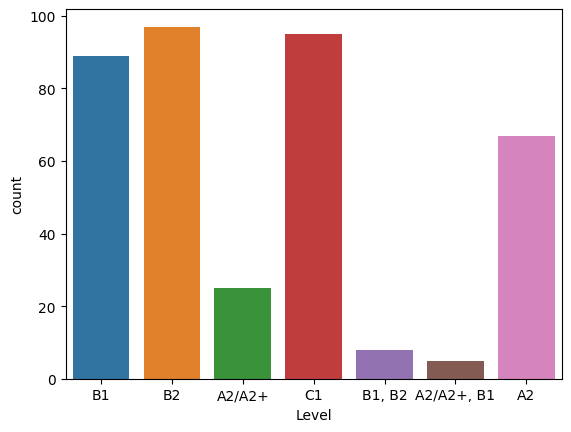

In [ ]:
#Изучим текущее распределение данных
sns.countplot(data=updated_df, x="Level")

B1    97
B2    97
A2    97
C1    95
Name: Level, dtype: int64

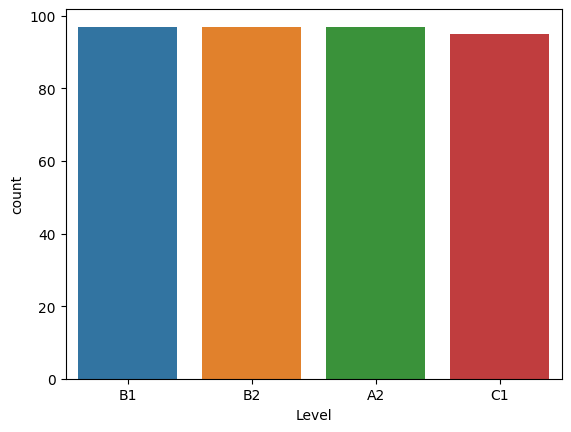

In [ ]:
for i in range(len(updated_df['Level'])):
  if updated_df.loc[i, 'Level'] == 'A2/A2+':
    updated_df.loc[i, 'Level'] = 'A2'
  elif updated_df.loc[i, 'Level'] == 'B1, B2':
    updated_df.loc[i, 'Level'] = 'B1'
  elif updated_df.loc[i, 'Level'] == 'А2':
    updated_df.loc[i, 'Level'] = 'A2'
  elif updated_df.loc[i, 'Level'] == 'A2/A2+, B1':
     updated_df.loc[i, 'Level'] = 'A2'

sns.countplot(data=updated_df, x="Level")
updated_df['Level'].value_counts()
#Не идеально, но уже значительно лучше

In [ ]:
# создаем список для хранения очищенных данных
updated_cleaned_text = []

for text in updated_df['Texts']:
    # очищаем данные
    text = re.sub("[^a-zA-Z]"," ",text)
    # приводим текст к нижнему регистру
    text = text.lower()
    # удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text)
    # Производим токенизацию
    text = word_tokenize(text)
    # с помощью цикла for поочередно проверяем каждое слово(токен) текущего сообщения
    # на вхождение в список стоп-слов. Если токен не является стоп-словом, то добавляем его в список
    text = [word for word in text if word not in stop_words]
    # для каждого слова из текущего сообщения вызываем функцию лемматизации
    text = [lemma(wd) for wd in text]
    # И приводим датасет в итоговому виду
    text = " ".join(text)
    # добавляем очищенные данные в список cleaned_text
    updated_cleaned_text.append(text)
# записываем очищенные данные в новую колонку 'Cleaned_txt'
updated_df['Cleaned_txt'] = updated_cleaned_text
# и изучаем результат
updated_df

,Movie,Level,Texts,Cleaned_txt
0,10_Cloverfield_lane(2016),B1,"<font color=""#ffff80""><b>Fixed & Synced by boz...",color ffff b fix sync bozxphd enjoy flick b cl...
1,10_things_I_hate_about_you(1999),B1,"Hey!\nI'll be right with you.\nSo, Cameron. He...",hey right cameron go nine school year army bra...
2,A_knights_tale(2001),B2,Resync: Xenzai[NEF]\nRETAIL\nShould we help hi...,resync xenzai nef retail help due list two min...
3,A_star_is_born(2018),B2,"- <i><font color=""#ffffff""> Synced and correct...",color ffffff sync correct b color ffd mrcjnthn...
4,Aladdin(1992),A2,"<i>Oh, I come from a land\nFrom a faraway plac...",oh come land faraway place caravan camel roam ...
...,...,...,...,...
381,Vicky.Cristina.Barcelona[2008]DvDrip-aXXo,C1,Vicky and Cristina decided\nto spend the summe...,vicky cristina decide spend summer barcelona v...
382,Warm Bodies_(2013)_en,C1,<i>What am I doing with my life?</i>\n<i>I'm s...,life pale get eat better posture terrible stan...
383,(eng)Searching.for.Sugar.Man.2012.720p.BRRip.x...,C1,"(# Sugar Man by Rodriguez)\n<i># Sugar Man, wo...",sugar man rodriguez sugar man hurry co tire sc...
384,10.Cloverfield.Lane.2016.720p.BRRip.x264.AAC-ETRG,C1,"<font color=""#D900D9"">(CLANGING)</font>\n<font...",color clang color drawer close color inaudible...


In [ ]:
X = updated_cleaned_text
y = updated_df["Level"].values
#Далее разделим выборку на тестовую и обучающую
from sklearn.model_selection import train_test_split
x_train, y_train, x_valid, y_valid = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [ ]:
# импортируем модуль CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer()
# проводим преобразование текста c помощью CountVectorizer
CV_train2 = count.fit_transform(x_train).toarray()
CV_test2 = count.transform(y_train).toarray()

In [ ]:
# импортируем модуль TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
#преобразуем текст
TFV_train2 = tfidf_vectorizer.fit_transform(x_train).toarray()
TFV_test2 = tfidf_vectorizer.transform(y_train).toarray()

In [ ]:
sentences = [sentence.split() for sentence in x_train]
w2v_model = Word2Vec(sentences, window=5, min_count=5, workers=4)

def vectorize2(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

W2V_train2 = np.array([vectorize(sentence) for sentence in x_train])
W2V_test2 = np.array([vectorize(sentence) for sentence in y_train])
W2V_train2

array([[-0.09394096,  0.26703468,  0.03186907, ...,  0.11312572,
         0.1376874 , -0.01618553],
       [ 0.01549188,  0.28284663, -0.08818303, ...,  0.15567993,
         0.20022807, -0.05371818],
       [-0.00395896,  0.30659115, -0.05357558, ...,  0.18894069,
         0.17101662, -0.09260166],
       ...,
       [ 0.06804983,  0.30582437, -0.14255473, ...,  0.26884252,
         0.3256782 , -0.11965586],
       [ 0.04415291,  0.28614432, -0.12812033, ...,  0.18267125,
         0.24698138,  0.01864988],
       [ 0.04886018,  0.20756923, -0.13253541, ...,  0.12054919,
         0.25151631, -0.05138547]])

Изучим результаты предсказания на данных, предобработанных с помощью- CountVectorizer

In [ ]:
x_train = CV_train2
y_train = CV_test2

In [ ]:
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(x_train, x_valid)
LR_predict = LR.predict(y_train)
print('Результат предсказания LogisticRegression', f1_score(y_valid, LR_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, LR_predict, average='micro'))

SVM = svm.SVC(decision_function_shape="ovo").fit(x_train, x_valid)
SVM_predict = SVM.predict(y_train)
print('Результат предсказания SVM', f1_score(y_valid, SVM_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, SVM_predict, average='micro'))

NB = GaussianNB().fit(x_train, x_valid)
NB_predict = NB.predict(y_train)
print('Результат предсказания GaussianNB', f1_score(y_valid, NB_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, NB_predict, average='micro'))

MultNB = MultinomialNB().fit(x_train, x_valid)
MultNB_predict = MultNB.predict(y_train)
print('Результат предсказания MultinomialNB', f1_score(y_valid, MultNB_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, MultNB_predict, average='micro'))


SGDC = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None).fit(x_train, x_valid)
SGDC_predict = SGDC.predict(y_train)
print('Результат предсказания SGDC', f1_score(y_valid, SGDC_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, SGDC_predict, average='micro'))

NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150, 10), random_state=1).fit(x_train, x_valid)
NN_predict = NN.predict(y_train)
print('Результат предсказания MLPClassifier', f1_score(y_valid, NN_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, NN_predict, average='micro'))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Результат предсказания LogisticRegression 0.5126436373953752
При этом точность- 0.5078125
Результат предсказания SVM 0.49692898719156076
При этом точность- 0.4921875
Результат предсказания GaussianNB 0.4360477572238286
При этом точность- 0.4296875
Результат предсказания MultinomialNB 0.5265242830013317
При этом точность- 0.5234375
Результат предсказания SGDC 0.47161471426177315
При этом точность- 0.4921875
Результат предсказания MLPClassifier 0.5041740825493686
При этом точность- 0.5


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
KN_model = KNeighborsClassifier()
KN_modelclassifier_params = {'n_neighbors':range(1, 50)}
KN_modelclassifier = best_model(KN_model, KN_modelclassifier_params, x_train, x_valid, y_train, y_valid)
KN_modelclassifier

(0.5040413544607036, {'n_neighbors': 3})

In [ ]:
RF_model = RandomForestClassifier(random_state=12345)
forestclassifier_params = {'n_estimators':range(1, 100, 10),
             'max_depth':range (1,20)}
RandomForest = best_model(RF_model, forestclassifier_params, x_train, x_valid, y_train, y_valid)
RandomForest

(0.5665595840002535, {'max_depth': 11, 'n_estimators': 91})

Изучим результаты предсказания на данных, предобработанных с помощью- Word2Vec

In [ ]:
x_train = TFV_train2
y_train = TFV_test2

In [ ]:
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(x_train, x_valid)
LR_predict = LR.predict(y_train)
print('Результат предсказания LogisticRegression', f1_score(y_valid, LR_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, LR_predict, average='micro'))

SVM = svm.SVC(decision_function_shape="ovo").fit(x_train, x_valid)
SVM_predict = SVM.predict(y_train)
print('Результат предсказания SVM', f1_score(y_valid, SVM_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, SVM_predict, average='micro'))

NB = GaussianNB().fit(x_train, x_valid)
NB_predict = NB.predict(y_train)
print('Результат предсказания GaussianNB', f1_score(y_valid, NB_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, NB_predict, average='micro'))

MultNB = MultinomialNB().fit(x_train, x_valid)
MultNB_predict = MultNB.predict(y_train)
print('Результат предсказания MultinomialNB', f1_score(y_valid, MultNB_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, MultNB_predict, average='micro'))


SGDC = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None).fit(x_train, x_valid)
SGDC_predict = SGDC.predict(y_train)
print('Результат предсказания SGDC', f1_score(y_valid, SGDC_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, SGDC_predict, average='micro'))

NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150, 10), random_state=1).fit(x_train, x_valid)
NN_predict = NN.predict(y_train)
print('Результат предсказания MLPClassifier', f1_score(y_valid, NN_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, NN_predict, average='micro'))

Результат предсказания LogisticRegression 0.49343979164699586
При этом точность- 0.4765625
Результат предсказания SVM 0.4511764705882353
При этом точность- 0.4453125
Результат предсказания GaussianNB 0.41918912620497306
При этом точность- 0.4140625
Результат предсказания MultinomialNB 0.30303583142848994
При этом точность- 0.359375
Результат предсказания SGDC 0.5049491140329649
При этом точность- 0.5078125
Результат предсказания MLPClassifier 0.4945852534562212
При этом точность- 0.484375


In [ ]:
KN_model = KNeighborsClassifier()
KN_modelclassifier_params = {'n_neighbors':range(1, 50)}
KN_modelclassifier = best_model(KN_model, KN_modelclassifier_params, x_train, x_valid, y_train, y_valid)
KN_modelclassifier

(0.44861113228281335, {'n_neighbors': 2})

In [ ]:
RF_model = RandomForestClassifier(random_state=12345)
forestclassifier_params = {'n_estimators':range(1, 100, 10),
             'max_depth':range (1,20)}
RandomForest = best_model(RF_model, forestclassifier_params, x_train, x_valid, y_train, y_valid)
RandomForest

(0.6046674998015922, {'max_depth': 9, 'n_estimators': 91})

Изучим результаты предсказания на данных, предобработанных с помощью- TfidfVectorizer


In [ ]:
x_train = W2V_train2
y_train = W2V_test2

In [ ]:
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(x_train, x_valid)
LR_predict = LR.predict(y_train)
print('Результат предсказания LogisticRegression', f1_score(y_valid, LR_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, LR_predict, average='micro'))

SVM = svm.SVC(decision_function_shape="ovo").fit(x_train, x_valid)
SVM_predict = SVM.predict(y_train)
print('Результат предсказания SVM', f1_score(y_valid, SVM_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, SVM_predict, average='micro'))

NB = GaussianNB().fit(x_train, x_valid)
NB_predict = NB.predict(y_train)
print('Результат предсказания GaussianNB', f1_score(y_valid, NB_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, NB_predict, average='micro'))

# MultinomialNB не получилось использовать, так как он выдает ошибку из-за передачи отрицательных данных
#MultNB = MultinomialNB().fit(x_train, x_valid)
#MultNB_predict = MultNB.predict(y_train)
#print('Результат предсказания MultinomialNB', f1_score(y_valid, MultNB_predict, average='macro'))

SGDC = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None).fit(x_train, x_valid)
SGDC_predict = SGDC.predict(y_train)
print('Результат предсказания SGDC', f1_score(y_valid, SGDC_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, SGDC_predict, average='micro'))

NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150, 10), random_state=1).fit(x_train, x_valid)
NN_predict = NN.predict(y_train)
print('Результат предсказания MLPClassifier', f1_score(y_valid, NN_predict, average='macro'))
print('При этом точность-', f1_score(y_valid, NN_predict, average='micro'))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Результат предсказания LogisticRegression 0.49588094841468155
При этом точность- 0.5
Результат предсказания SVM 0.39390635918937805
При этом точность- 0.4296875
Результат предсказания GaussianNB 0.37211711711711715
При этом точность- 0.40625
Результат предсказания SGDC 0.5062567713976165
При этом точность- 0.515625
Результат предсказания MLPClassifier 0.5267901497409694
При этом точность- 0.53125


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
KN_model = KNeighborsClassifier()
KN_modelclassifier_params = {'n_neighbors':range(1, 50)}
KN_modelclassifier = best_model(KN_model, KN_modelclassifier_params, x_train, x_valid, y_train, y_valid)
KN_modelclassifier

(0.544163339044108, {'n_neighbors': 6})

In [ ]:
RF_model = RandomForestClassifier(random_state=12345)
forestclassifier_params = {'n_estimators':range(1, 100, 10),
             'max_depth':range (1,20)}
RandomForest = best_model(RF_model, forestclassifier_params, x_train, x_valid, y_train, y_valid)
RandomForest

(0.5832410808060446, {'max_depth': 3, 'n_estimators': 31})

Выводы по результатам работы:

Лучшая модель показала результат - 0.64 (F1_macro) на тестовой выборке, после обучения модели с использованием, "наивного" Байесовского классификатора (GaussianNB ), обученного на признаках, предобработанных при помощи- CountVectorized. Метрики F1_weighted удалось достичь - 0.67.

Основной метрикой в данной задаче, мной была выбрана метрика- f1_macro, так как была важна точность предсказания по всем из используемых классов.

При этом, наилучший результат был получен именно на изначальной выборке с дисбалансом классов, в то время как выборка с устраненным на основании размеченных другим сервисом данных не принесла желаемого результата. И хотя устранение дисбаланса помогло повысить метрику точности, наибольший результат предсказания показала модель обученная на данных с дисбалансом. Из чего можно сделать вывод, что первончальные данные размечались напрямую человеком и подвержены определенной доли субъективности, из-за чего расширение датасета за счет моделей, размеченных по уровню сложности исходя из используеммых в данных слов и не дало результата.

Что стоит сделать в будущем? (Мысли по улучшению модели)
- Изучить на предсказание каких классов модель ошибается чаще всего и за счет этого внести дополнительные улучшения в модель
- Подумать какие дополнительные признаки, можно добавить к модели (возможно частоту упминания слов из Оксфордского словаря по классам, имеющемся в датасете)
- Собрать больше фильмов с размеченным уровнем сложности с одинаковым количеством в каждом классе, включая уровень A1. Это поможет улучшить прогностические способности модели.
- Возможно стоит полностью исключить из алгоритма первоначальную разметку, так как она не лишена субъективности, что мешает дополнить датасет новыми данными на основе разметки с использованием машинного обучения, например- https://towardsdatascience.com/the-best-netflix-movies-series-to-learn-english-according-to-data-science-dec7b047b164